### Notebook setup

In [1]:
 # This is boilerplate code to correctly setup the settings to for notebook.
import os, sys
for root, dirs, files in os.walk(os.getcwd()):
    print(root)
    if "pi0-analysis" in root.split("/"):
        pypath = root.split("pi0-analysis")[0] + "/pi0-analysis/analysis"
        print(pypath)
        break

sys.path.insert(0, pypath)

from python.analysis.NotebookUtils import init_notebook
%init_notebook

/home/pemb6649/pi0-analysis/analysis/summer-placement
/home/pemb6649//pi0-analysis/analysis
/home/pemb6649//pi0-analysis/analysis
env: PYTHONPATH=/home/pemb6649//pi0-analysis/analysis


In [31]:
from rich import print

# Note these are examples of the mose useful/common libraries to rely on
from python.analysis import (
    Master, # Core library for Ntuple file manipulation
    BeamParticleSelection, # Defined selections for the beam particle.
    PFOSelection, # Defined selections for (Particle Flow Objects) PFOs
    Plots, # Plotting functions
    vector, # doing vector operations using Awkward.
    Tags, # Creating event tags
    cross_section, # Helper functions specifically for the cross section analysis code
    EventSelection, # Helper functions for event selection,
    SelectionTools # Helper functions for event selection
)# Fo


from apps.cex_analysis_input import BeamPionSelection

import awkward as ak # library for manipulating vectors faster than numpy
import numpy as np

from particle import Particle

cross_section.PlotStyler.SetPlotStyle(dpi = 100, dark = True) # set the plot style to use (aesthetics)

In [30]:
# required libraries for the ML approach

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# models

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# other

import pickle
from datetime import datetime
import dill

# custom functions

from utils import extract_observables, clean_df, split_data, accuracy, purity, efficiency
from utils import plot_feature_importances, create_confusion_matrix, plot_confusion_matrix
from utils import master_pion_selection, tune_hp, save_hp_tuning_results, find_best_hps


In [46]:
# define mc data

mc = Master.Data("/data/dune/common/PDSPAnalyzer_Ntuples/PDSPProd4a_MC_2GeV_sce_datadriven_ntuple_v09_81_00d01_set0.root", nTuple_type = Master.Ntuple_Type.PDSP, target_momentum = 2)
print(f"Original events: {len(mc.eventNum)}")

Original events: 131266

In [198]:
# Load the beam selection mask

beam_mask = Master.LoadObject("/home/pemb6649/pi0-analysis/analysis/work/analysis_demo/masks_mc/beam_selection_masks.dill")
mask = beam_mask[mc.filename]
combined_mask = SelectionTools.CombineMasks(mask)
i = 0
for mask in combined_mask:
    if mask == True:
        i += 1
print(f"Beam selected events: {i}")

Beam selected events: 31476

In [212]:
data = extract_observables(mc, size=10000, beam_selection_mask=combined_mask, verbose=True)
print(data[0])

/home/pemb6649/miniforge3/envs/python3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pemb6649/miniforge3/envs/python3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Considered 10000 original events.
Rejected 7581 events through beam selection.
Skipped 0 tracks due to errors.
Number of tracks: 9428


{
    'track_dEdX_mean': 2.558226866381509,
    'track_dEdX_median': 1.9872541427612305,
    'track_dQdX_mean': 71.89189985820225,
    'track_dQdX_median': 60.625261306762695,
    'residual_range_mean': 4.318397667791162,
    'residual_range_median': 4.346254587173462,
    'track_chi2/ndof_proton': 189.4326764168931,
    'track_chi2/ndof_pion': 21.373347526616104,
    'track_chi2/ndof_muon': 14.285213670655741,
    'track_length': 7.555305181307957,
    'track_score': 0.08923625445106265,
    'particle': '$\\gamma$',
    'track_vertex_michel': 6.598455097293424,
    'track_vertex_nhits': 20,
    'hit_density': 4.367791797695076,
    'angle_to_beam': -42.723208316221644
}

### Data manipulation

In [200]:
df = pd.DataFrame(data)
df.head()

,track_dEdX_mean,track_dEdX_median,track_dQdX_mean,track_dQdX_median,residual_range_mean,residual_range_median,track_chi2/ndof_proton,track_chi2/ndof_pion,track_chi2/ndof_muon,track_length,track_score,particle,track_vertex_michel,track_vertex_nhits,hit_density,angle_to_beam
0,2.558227,1.987254,71.891900,60.625261,4.318398,4.346255,189.432676,21.373348,14.285214,7.555305,0.089236,$\gamma$,6.598455,20,4.367792,-42.723208
1,2.185762,2.032390,65.696295,61.969856,2.672577,2.669007,215.380424,24.721273,16.334994,7.812130,0.494838,$\pi^{\pm}$:2nd,5.771489,44,1.024048,-37.166300
2,2.697233,1.803803,70.462522,55.478149,47.342638,46.573074,166.324808,17.563040,14.788307,94.991625,0.875237,$\pi^{\pm}$:2nd,4.309568,9,1.484341,-88.575353
3,46.238247,6.665603,246.978881,157.095474,13.027541,13.389076,1.984713,35.581015,36.443756,23.881886,0.948290,$p$,0.000004,2,2.009892,-113.253265
4,0.957016,0.802299,27.266159,22.506063,2.434822,1.759761,285.341374,44.145326,30.075351,8.760562,0.002080,$\gamma$,5.272155,13,1.483923,-50.220107


In [201]:
df = clean_df(df, verbose=True)
x_train, x_test, y_train, y_test = split_data(df, verbose=True)

Removed 1149 rows with missing entries. 
Training set size: 6623 tracks.
Testing set size: 1656 tracks.


### Training model

In [202]:
# define and train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
model.fit(x_train, y_train);
y_pred = model.predict(x_test).tolist()
y_test = y_test.tolist()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [203]:
# quick look at the output
pred_df = pd.DataFrame({
    "predicted": y_pred,
    "true": y_test
})
pred_df.head(20)

,predicted,true
0,$p$,$p$
1,$\gamma$,$\gamma$
2,$p$,$\pi^{\pm}$:2nd
3,$p$,$p$
4,$\gamma$,$\gamma$
5,$p$,$p$
6,$\pi^{\pm}$,$\mu^{\pm}$
7,$p$,$p$
8,$\pi^{\pm}$,$\pi^{\pm}$
9,$\gamma$,$\pi^{\pm}$:2nd


### Performance metrics

In [204]:
pions = ["$\pi^{\pm}$"]

#print(f"General accuracy: {accuracy(y_pred, y_test):.3f}")
#print("--------------------------------")
#print(f"pi+ purity: {purity(y_pred, y_test, pi_plus, pi_plus):.3f}")
#print(f"pi+ efficiency: {efficiency(y_pred, y_test, pi_plus, pi_plus):.3f}")
#print("--------------------------------")
#print(f"pi- purity: {purity(y_pred, y_test, pi_minus, pi_minus):.3f}")
#print(f"pi- efficiency: {efficiency(y_pred, y_test, pi_minus, pi_minus):.3f}")
#print("--------------------------------")
print(f"Charged pion purity: {purity(y_pred, y_test, pions, pions):.3f}")
print(f"Charged pion efficiency: {efficiency(y_pred, y_test, pions, pions):.3f}")

Charged pion purity: 0.588

Charged pion efficiency: 0.709

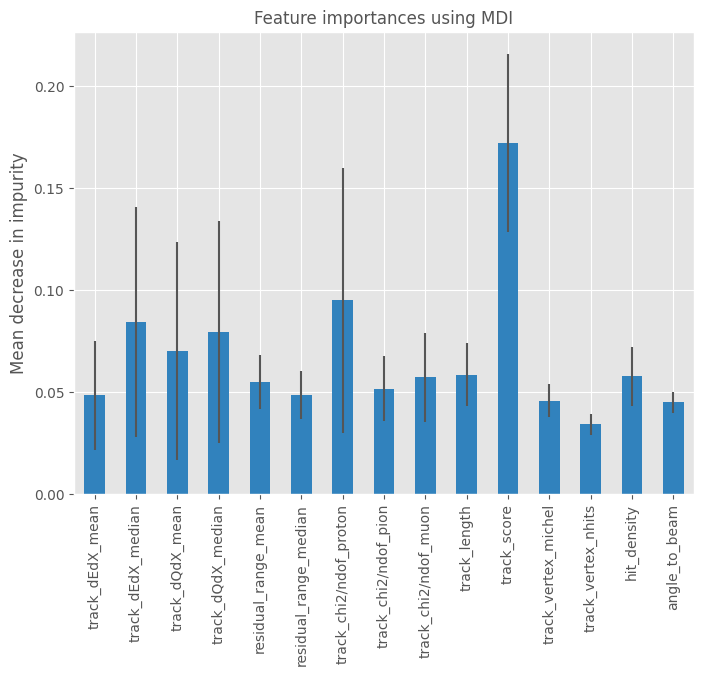

In [205]:
plot_feature_importances(model, x_train)

### Master function demo

In [ ]:
data = extract_observables(mc, size=10000, beam_selection_mask=combined_mask, verbose=True)

Removed 1149 rows with missing entries. 
Training set size: 6623 tracks.
Testing set size: 1656 tracks.
Fitting model...
Model fitted.
accuracy: 0.719
pi± purity: 0.000
pi± efficiency: 0.000


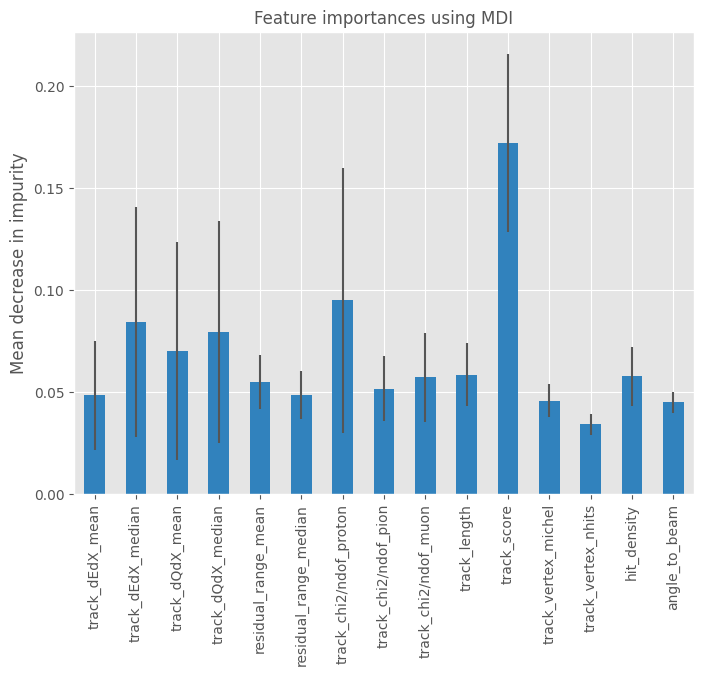

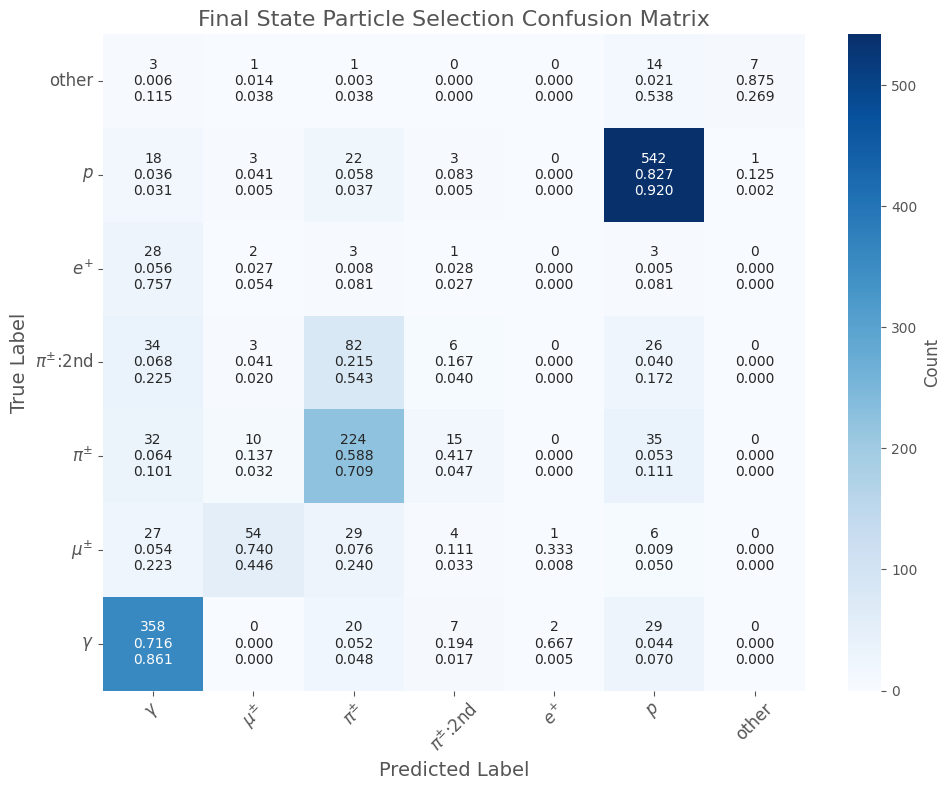

In [206]:
fitted_model, pion_purity, pion_efficiency = master_pion_selection(data=data, verbose=True, plot_importances=True, plot_cm=True)

# or let the master_pion_selection extract the data for you:
# fitted_model, pion_purity, pion_efficiency = master_pion_selection(ntuple=mc, size=10000, verbose=True, plot_importances=True, plot_cm=True)

### Decision Tree

In [77]:
# let's increase the training dataset
data = extract_observables(mc, 10000)

/home/pemb6649/miniforge3/envs/python3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pemb6649/miniforge3/envs/python3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Removed 3603 rows with missing entries. No rows with missing entries remaining.
Training set size: 21245 tracks.
Testing set size: 5312 tracks.
Fitting model...
Model fitted.
accuracy: 0.650
pi± purity: 0.657
pi± efficiency: 0.645
Cannot calculate standard deviation of feature importances.


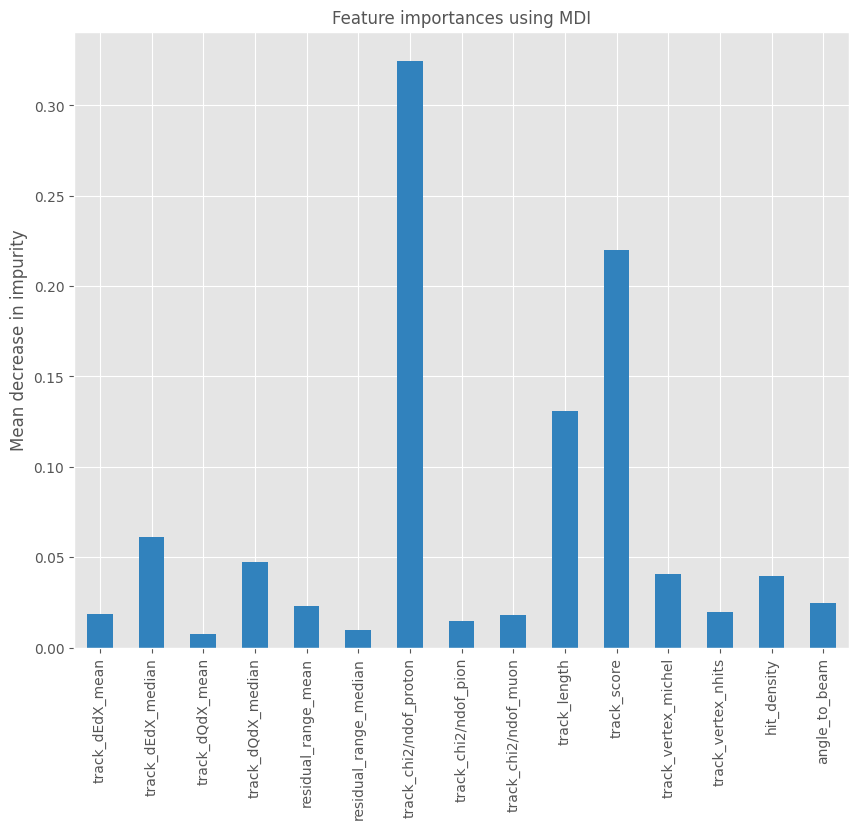

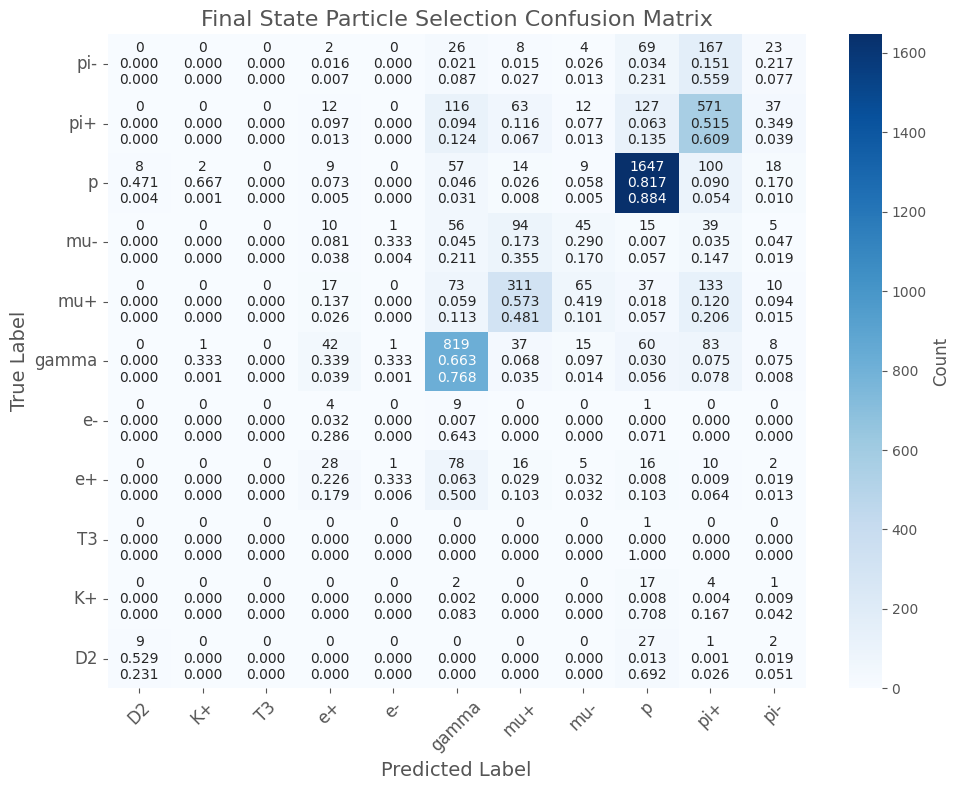

In [14]:
DT = DecisionTreeClassifier(max_depth=10, random_state=42)
DT, pion_purity, pion_efficiency = master_pion_selection(data=data, model=DT, verbose=True, plot_importances=True, plot_cm=True)

### Random Forest

In [226]:
data = extract_observables(mc, size=20000, beam_selection_mask=combined_mask, verbose=True)

/home/pemb6649/miniforge3/envs/python3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pemb6649/miniforge3/envs/python3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Considered 20000 original events.
Rejected 15150 events through beam selection.
Skipped 0 tracks due to errors.
Number of tracks: 18920


Removed 2357 rows with missing entries. 
Training set size: 13250 tracks.
Testing set size: 3313 tracks.
Fitting model...
Model fitted.
accuracy: 0.724
pi± purity: 0.585
pi± efficiency: 0.697


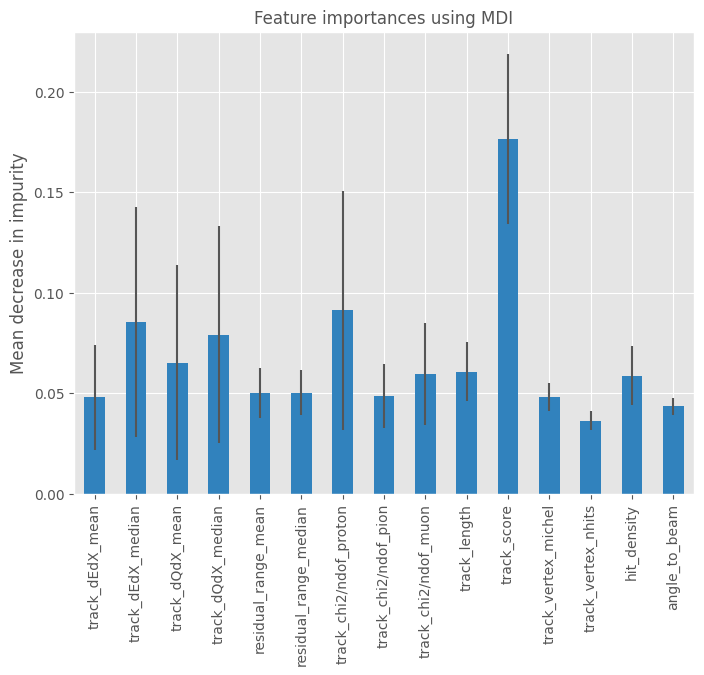

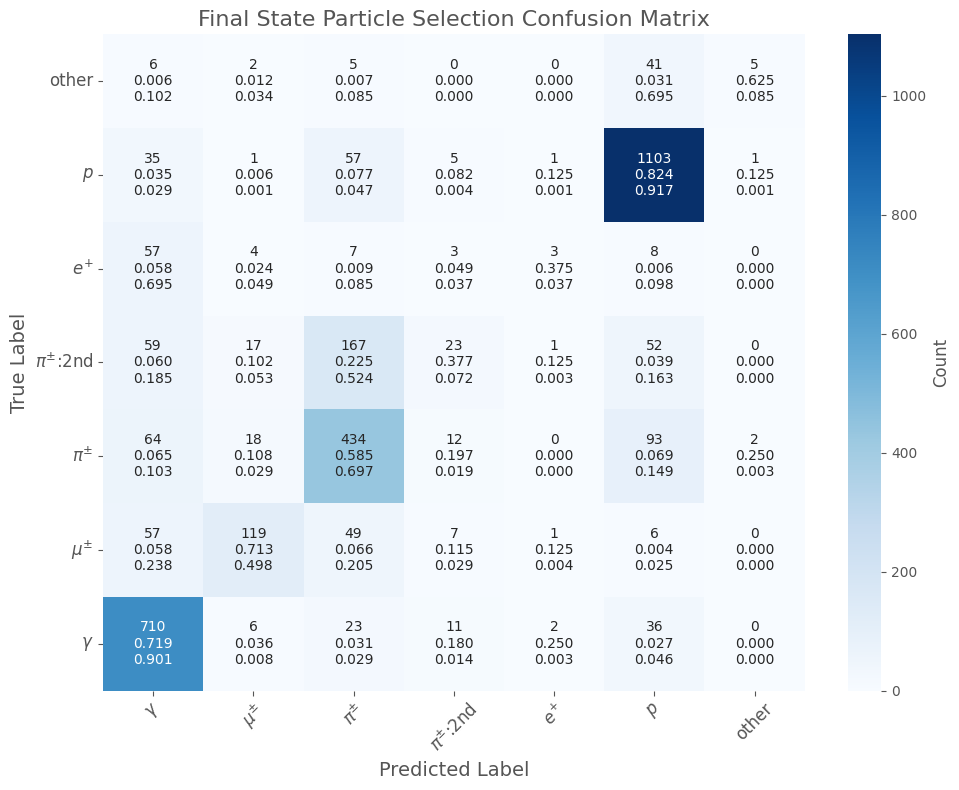

In [227]:
RF = RandomForestClassifier(n_estimators=100, random_state=42);
RF, pion_purity, pion_efficiency = master_pion_selection(data=data, model=RF, verbose=True, plot_importances=True, plot_cm=True, binary_classification=False, consider_dropped_rows=False)

TUNING RANDOM FOREST HYPERPARAMETERS
Purity: 0.538, Efficiency: 0.601
Purity: 0.563, Efficiency: 0.619
Purity: 0.673, Efficiency: 0.551
Purity: 0.701, Efficiency: 0.581


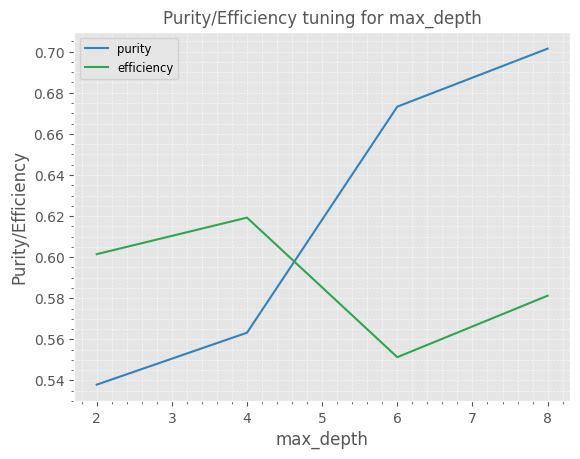

In [16]:
rf_hyper_param_tuning = {
    "max_depth": np.arange(2, 10, 2),
}

hp_tuning_results = tune_hp(rf_hyper_param_tuning, data, "rf", plot=True, save=True);

TUNING RANDOM FOREST HYPERPARAMETERS
Purity: 0.725, Efficiency: 0.595
Purity: 0.729, Efficiency: 0.615
Purity: 0.724, Efficiency: 0.618
Purity: 0.724, Efficiency: 0.616
Purity: 0.732, Efficiency: 0.616
Purity: 0.730, Efficiency: 0.615
Purity: 0.728, Efficiency: 0.622
Purity: 0.737, Efficiency: 0.624
Purity: 0.734, Efficiency: 0.621


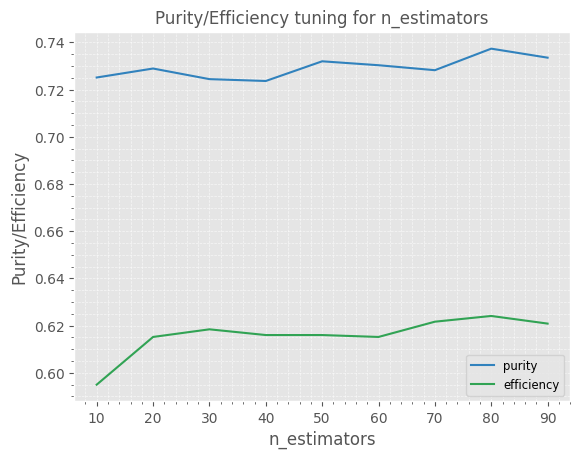

In [17]:
rf_hyper_param_tuning = {
    "n_estimators": np.arange(10, 100, 10),
}

hp_tuning_results = tune_hp(rf_hyper_param_tuning, data, "rf", plot=True, save=True);

In [ ]:
rf_hyper_param_tuning = {
    "min_samples_leaf": np.arange(1, 10, 1),
    "min_samples_split": np.arange(2, 10, 1)
}

hp_tuning_results = tune_hp(rf_hyper_param_tuning, data, "rf", plot=True, save=True);

### XGBoost

In [95]:
xgb = XGBClassifier(n_estimators=32, max_depth=5, learning_rate=0.15, random_state=42, scale_pos_weight=16)
xgb = master_pion_selection(ntuple=mc, data=data, model=xgb, verbose=True, plot_importances=False, plot_cm=False)

Removed 47626 rows with missing entries. No rows with missing entries remaining.
Training set size: 275289 tracks.
Testing set size: 68823 tracks.
Fitting model...
[15:47:19] WARNING: ../src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Model fitted.
accuracy: 0.688
pi± purity: 0.710
pi± efficiency: 0.617


In [ ]:
xgb_hyper_param_tuning = {
    "max_depth": [1, 3, 5, 10],
    "n_estimators": [1, 2, 4, 8, 16, 32],
    "learning_rate": [0.05, 0.1, 0.2, 0.5, 1]
}

hp_tuning_results = tune_hp(xgb_hyper_param_tuning, data, "xgb", plot=True, save=True, verbose=True);

### Multi-Layer Perceptron (MLP) Classifier

In [91]:
data = extract_observables(mc, -1)

/home/pemb6649/miniforge3/envs/python3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pemb6649/miniforge3/envs/python3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [93]:
mlp = MLPClassifier(max_iter=1000, random_state=42, hidden_layer_sizes=(64))
mlp = master_pion_selection(data=data, model=mlp, verbose=True, plot_importances=False, plot_cm=False)

Removed 47626 rows with missing entries. No rows with missing entries remaining.
Training set size: 275289 tracks.
Testing set size: 68823 tracks.
Fitting model...
Model fitted.
accuracy: 0.613
pi± purity: 0.570
pi± efficiency: 0.514


### Binary classification approach

In [220]:
data = extract_observables(mc, size=20000, beam_selection_mask=combined_mask, verbose=True)

Considered 20000 original events.
Rejected 15150 events through beam selection.
Skipped 0 tracks due to errors.
Number of tracks: 18920


Removed 2357 rows with missing entries. 


/home/pemb6649/pi0-analysis/analysis/summer-placement/utils.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else:
/home/pemb6649/pi0-analysis/analysis/summer-placement/utils.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if y[i] == "$\pi^{\pm}$":


Training set size: 13250 tracks.
Testing set size: 3313 tracks.
Fitting model...
Model fitted.
accuracy: 0.857
pi± purity: 0.678
pi± efficiency: 0.453


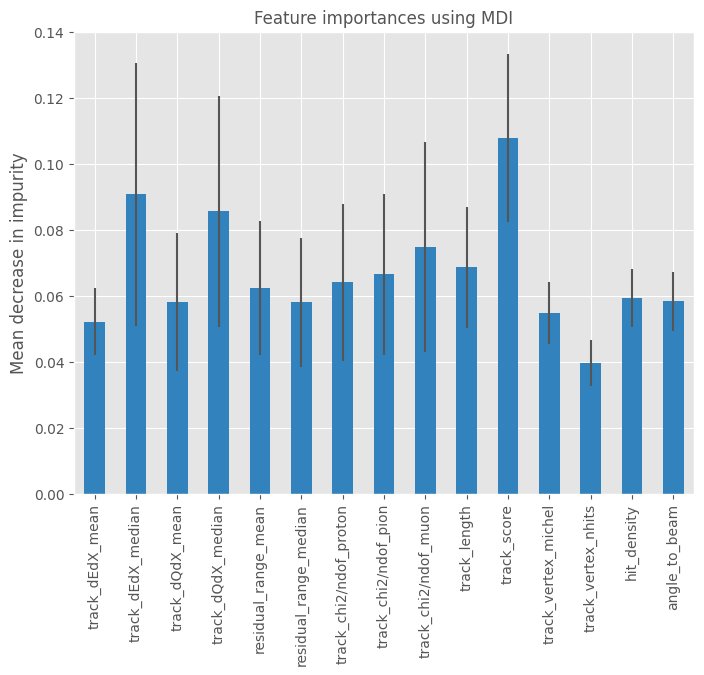

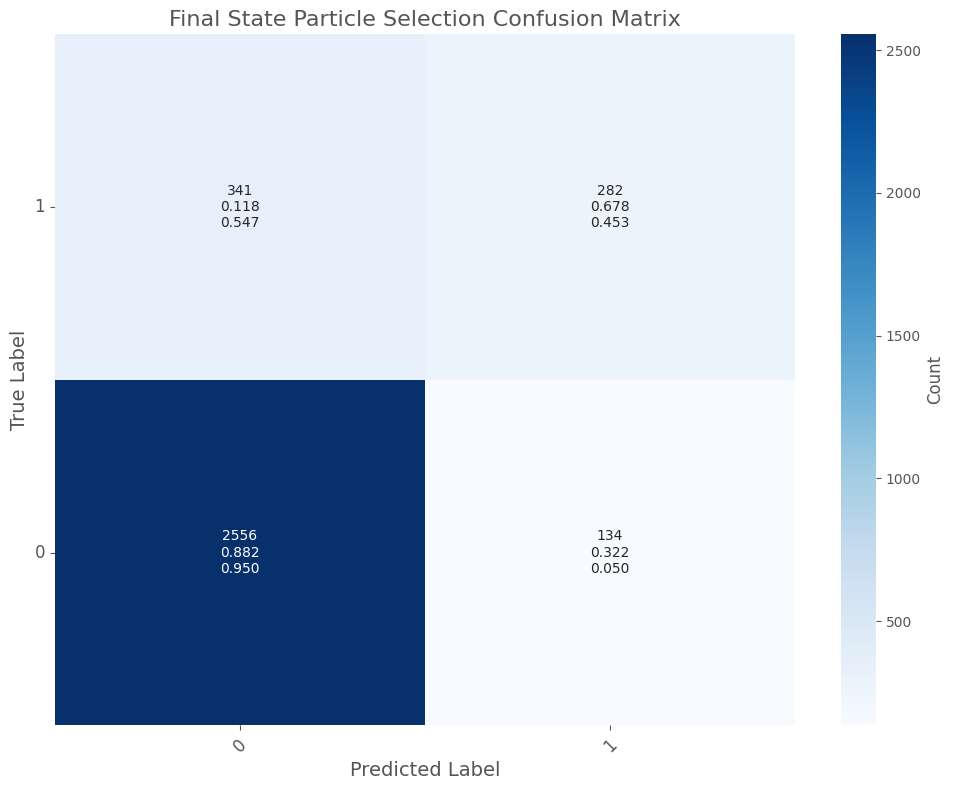

In [223]:
RF = RandomForestClassifier(n_estimators=100, random_state=42);
RF, pion_purity, pion_efficiency = master_pion_selection(data=data, model=RF, verbose=True, plot_importances=True, plot_cm=True, binary_classification=True, consider_dropped_rows=False)